In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
from keras.utils import to_categorical
from collections import OrderedDict
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [2]:
from platform import python_version
print(python_version())

3.6.6


### Exp of classifing movie genres based on their events.


In [3]:
movies = pd.read_csv('../../data/metadata_events_table.tsv', sep = '\t')

In [4]:
movies.Genre_code.value_counts()

2    1733
1    1165
4     494
0     345
3     103
Name: Genre_code, dtype: int64

In [5]:
# df0 = movies[movies['Genre_code'] == 0].sample(500, replace = True)
# df1 = movies[movies['Genre_code'] == 1].sample(500)
# df2 = movies[movies['Genre_code'] == 2].sample(500)
# df3 = movies[movies['Genre_code'] == 3].sample(500)
# df4 = movies[movies['Genre_code'] == 4].sample(500)

In [6]:
# movies = pd.concat([df0, df1, df2, df3, df4])

In [7]:
len(movies)

3840

In [8]:
movies = movies.sort_values('Genre_code').reset_index()

In [9]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

In [10]:
#starting and ending index for each group for plotting
action_s = min(movies[movies['Genre_code'] == 0].index.tolist())
action_e = max(movies[movies['Genre_code'] == 0].index.tolist())
comedy_s = min(movies[movies['Genre_code'] == 1].index.tolist())
comedy_e = max(movies[movies['Genre_code'] == 1].index.tolist())
drama_s = min(movies[movies['Genre_code'] == 2].index.tolist())
drama_e = max(movies[movies['Genre_code'] == 2].index.tolist())
romance_s = min(movies[movies['Genre_code'] == 3].index.tolist())
romance_e = max(movies[movies['Genre_code'] == 3].index.tolist())
thriller_s = min(movies[movies['Genre_code'] == 4].index.tolist())
thriller_e = max(movies[movies['Genre_code'] == 4].index.tolist())


In [11]:
for item in movies[movies['Genre_code'] == 4].Events.head(20).tolist():
    print(item)
    print()

['amuse-31.1', 'get-13.5.1', 'appear-48.1.1', 'sight-30.2', 'meander-47.7', 'own-100', 'correspond-36.1', 'other_cos-45.4', 'get-13.5.1', 'sustain-55.6', 'discover-84', 'disregard', 'lodge-46', 'spray-9.7-1', 'meet-36.3-1', 'escape-51.1-1', 'fit-54.3', 'discover-84', 'future_having-13.3', 'get-13.5.1', 'escape-51.1-1', 'remove-10.1', 'discover-84', 'wish-62', 'amuse-31.1', 'escape-51.1', 'destroy-44', 'roll-51.3.1', 'meander-47.7', 'put_direction-9.4', 'meander-47.7']

['confront-98', 'become-109.1-1', 'fulfilling-13.4.1-1', 'order-60-1', 'want-32.1-1-1', 'get-13.5.1', 'future_having-13.3', 'conjecture-29.5-1', 'correspond-36.1-1', 'tell-37.2', 'reflexive_appearance-48.1.2', 'meander-47.7', 'advise-37.9', 'give-13.1-1', 'give-13.1-1', 'want-32.1-1-1', 'murder-42.1', 'future_having-13.3', 'escape-51.1', 'hunt-35.1', 'tell-37.2', 'conjecture-29.5-1', 'transfer_mesg-37.1.1-1-1', 'transfer_mesg-37.1.1-1-1', 'obtain-13.5.2', 'become-109.1-1', 'future_having-13.3', 'mix-22.1-2-1', 'soliloqui

### Encode as one-hot vectors

In [12]:
t = Tokenizer()

In [13]:
events = []
for e in movies.Events.tolist():
    events.append([item.split('-')[0] for item in eval(e)])

In [14]:
# Size of data
print(len(events))

3840


In [15]:
t.fit_on_texts(events)

In [16]:
t.word_index

{'amuse': 1,
 'get': 2,
 'escape': 3,
 'discover': 4,
 'own': 5,
 'meander': 6,
 'transfer_mesg': 7,
 'become': 8,
 'conjecture': 9,
 'other_cos': 10,
 'say': 11,
 'correspond': 12,
 'force': 13,
 'obtain': 14,
 'appear': 15,
 'run': 16,
 'convert': 17,
 'meet': 18,
 'give': 19,
 'admire': 20,
 'characterize': 21,
 'future_having': 22,
 'begin': 23,
 'contiguous_location': 24,
 'steal': 25,
 'admit': 26,
 'subjugate': 27,
 'reflexive_appearance': 28,
 'seem': 29,
 'send': 30,
 'judgment': 31,
 'sight': 32,
 'remove': 33,
 'exist': 34,
 'marvel': 35,
 'calibratable_cos': 36,
 'involve': 37,
 'tell': 38,
 'crane': 39,
 'fit': 40,
 'appoint': 41,
 'contribute': 42,
 'urge': 43,
 'put': 44,
 'confront': 45,
 'lodge': 46,
 'refuse': 47,
 'try': 48,
 'help': 49,
 'see': 50,
 'wish': 51,
 'consider': 52,
 'want': 53,
 'throw': 54,
 'disappearance': 55,
 'dub': 56,
 'sound_emission': 57,
 'sustain': 58,
 'resign': 59,
 'manner_speaking': 60,
 'learn': 61,
 'order': 62,
 'chase': 63,
 'stop': 6

In [17]:
embedding_input_dim = max(t.word_index.values())+1

In [18]:
embedding_input_dim

857

In [19]:
msk = np.random.rand(len(movies)) < 0.8
train = []
for e in movies[msk]['Events'].tolist():
    train.append([item.split('-')[0] for item in eval(e)])
test = []
for e in movies[~msk]['Events'].tolist():
    test.append([item.split('-')[0] for item in eval(e)])


In [20]:
x_train = t.texts_to_sequences(train)
x_train = pad_sequences(x_train, maxlen=50)


In [21]:
events_trans = t.texts_to_sequences(events)
events_trans = pad_sequences(events_trans, maxlen=50)


In [22]:
x_test = t.texts_to_sequences(test)
x_test = pad_sequences(x_test, maxlen=20)


In [23]:
y_train = to_categorical(movies[msk]['Genre_code'].tolist())
y_test = to_categorical(movies[~msk]['Genre_code'].tolist())

### Simple LSTM 

In [24]:
# create the model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(embedding_input_dim, embedding_vector_length))
model.add( LSTM(20))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          27424     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4240      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 31,769
Trainable params: 31,769
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
3090/3090 [==============================] - 3s 869us/step - loss: 1.3838 - acc: 0.4346
Epoch 2/3
3090/3090 [==============================] - 2s 704us/step - loss: 1.2961 - acc: 0.4521
Epoch 3/3
3090/3090 [==============================] - 2s 715us/step - loss: 1.2674 - acc: 0.4537


In [25]:
# Final evaluation of the model
scores = model.evaluate(x_test,
                        y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 0s 171us/step
Accuracy: 45.73%


### Obtain embeddings

In [26]:
# #Get indimediate layer output using tensorflow backend
# get_lstm_output = K.function([model.layers[0].input], [model.layers[1].output])
# output = get_lstm_output([x_train])

In [28]:
#Alternative way, same result
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('lstm_1').output)
# intermediate_output = intermediate_layer_model.predict(x_train[0][0:])

In [29]:
vecs = []
for i in range(len(events)):
    output = intermediate_layer_model.predict(events_trans[i])
#     print(output.shape)
#     print(output[0])
#     break
    vecs.append(output[-1])


### Cluster embeddings

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [39]:
embedded = TSNE(n_components=2).fit_transform(vecs)
embedded.shape

(3840, 2)

In [32]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

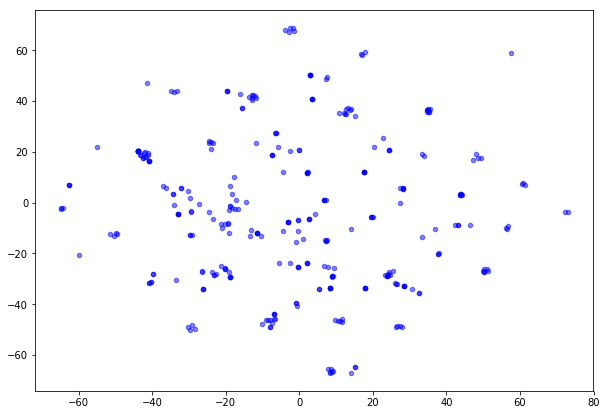

In [45]:
plt.figure(figsize = (10,7))
plt.scatter(embedded[action_s:action_e,0], embedded[action_s:action_e,1], s = 20,color='blue', label = 'Action', alpha = 0.5)
# plt.scatter(embedded[comedy_s:comedy_e,0], embedded[comedy_s:comedy_e,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)
# plt.scatter(embedded[drama_s:drama_e,0], embedded[drama_s:drama_e,1], s = 20,color='red', label = 'Drama', alpha = 0.5)
# plt.scatter(embedded[romance_s:romance_e,0], embedded[romance_s:romance_e,1], s = 20,color='green', label = 'Romance', alpha = 0.5)
# plt.scatter(embedded[thriller_s:thriller_e,0], embedded[thriller_s:thriller_e,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
# # plt.legend()

In [46]:
pca = PCA(n_components=2)
embedded = pca.fit_transform(vecs)

In [47]:
embedded.shape

(3840, 2)

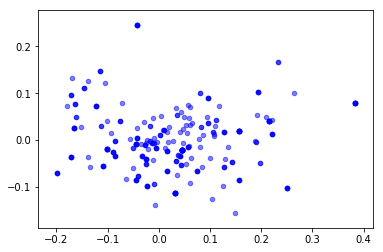

In [57]:
# plt.figure(figsize = (10,7))
plt.scatter(embedded[action_s:action_e,0], embedded[action_s:action_e,1], s = 20,color='blue', label = 'Action', alpha = 0.5)

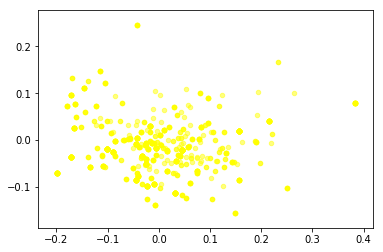

In [58]:
plt.scatter(embedded[comedy_s:comedy_e,0], embedded[comedy_s:comedy_e,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)

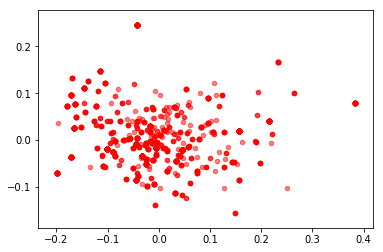

In [59]:
plt.scatter(embedded[drama_s:drama_e,0], embedded[drama_s:drama_e,1], s = 20,color='red', label = 'Drama', alpha = 0.5)

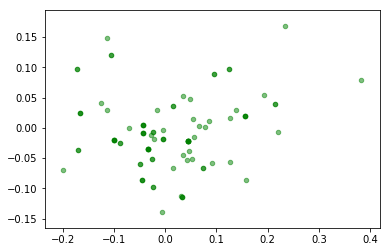

In [60]:
plt.scatter(embedded[romance_s:romance_e,0], embedded[romance_s:romance_e,1], s = 20,color='green', label = 'Romance', alpha = 0.5)

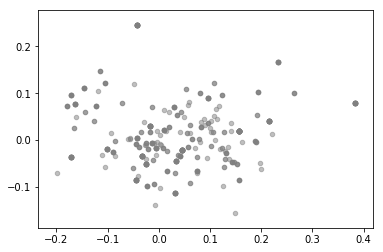

In [61]:
plt.scatter(embedded[thriller_s:thriller_e,0], embedded[thriller_s:thriller_e,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
# plt.legend()

In [37]:
print(pca.explained_variance_ratio_)  

[0.69169824 0.24952385]


In [38]:
print(pca.singular_values_)  

[6.94618239 4.17199591]
